<a href="https://colab.research.google.com/github/salimbeni1/DB-IntroProject/blob/master/pth_geo_setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

{{ badge }}

In [1]:
! python -c "import torch; print('cuda version : ' , torch.version.cuda)"
! python -c "import torch; print('pytorch version : ' ,torch.__version__)"

cuda version :  10.1
pytorch version :  1.7.0+cu101


make sure that you install a compatible pytorch geometric version, here for example for 1.7.0+cu101 

In [2]:
%%bash
pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
  Created wheel for torch-geometric: filename=torch_geometric-1.6.3-cp36-none-any.whl size=322720 sha256=0d0a5edc7d07109c514fddeefd0395d534a369aa2804496752e239b81fe493e2
  Stored in directory: /root/.cache/pip/wheels/6d/47/1e/0af8ce3e21783c3e584c22502011a3367c091694eebc50a971
Successfully built torch-geometric


# **PYTORCH GEOMETRIC intro example**

In [3]:
import torch
from torch_geometric.data import Data

# all edges in the graph with shape [ 2 , nb_edges ]
# use edge_index.t().contiguous() for shape [ nb_edges , 2 ]
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)


# feature vector of each node with shape [ nb_nodes , nb_features ] ( here 1 dimension )
x = torch.tensor([[-1,2], [0, 2], [1, 2]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

data

Data(edge_index=[2, 4], x=[3, 2])

In [4]:
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES' , use_node_attr=True)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

for batch in loader:
    print(batch)
    print(batch.batch) # to which graph the node index is in the batch
    print(batch.num_graphs)
    break

# u can use : import torch_geometric.transforms as T, to modify the dataset for example :  

Extracting /tmp/ENZYMES/ENZYMES/ENZYMES.zip
Processing...
Done!
Batch(batch=[1028], edge_index=[2, 4014], x=[1028, 21], y=[32])
tensor([ 0,  0,  0,  ..., 31, 31, 31])
32


In [5]:
from torch_geometric.datasets import Planetoid
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

dataset = Planetoid(root='/tmp/Cora', name='Cora')


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

Processing...
Done!


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(10):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    print(loss)

tensor(1.9523, grad_fn=<NllLossBackward>)
tensor(1.8488, grad_fn=<NllLossBackward>)
tensor(1.7244, grad_fn=<NllLossBackward>)
tensor(1.5880, grad_fn=<NllLossBackward>)
tensor(1.4203, grad_fn=<NllLossBackward>)
tensor(1.3007, grad_fn=<NllLossBackward>)
tensor(1.1425, grad_fn=<NllLossBackward>)
tensor(1.0646, grad_fn=<NllLossBackward>)
tensor(0.9185, grad_fn=<NllLossBackward>)
tensor(0.8286, grad_fn=<NllLossBackward>)


In [7]:
model.eval()
_, pred = model(data).max(dim=1)
correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / int(data.test_mask.sum())
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.6860


# **MOLECULE Graph Neural Network !!!!!**

In [8]:
!pip install pysmiles

  Using cached https://files.pythonhosted.org/packages/fb/48/69046506f6ac61c1eaa9a0d42d22d54673b69e176d30ca98e3f61513e980/pbr-5.5.1-py2.py3-none-any.whl
  Created wheel for pysmiles: filename=pysmiles-1.0.1-py2.py3-none-any.whl size=22017 sha256=1821e85274c0a22dcc131d2b1568edeef4cbe58c260b507ca520b44feb4f8606
  Stored in directory: /root/.cache/pip/wheels/2e/ba/9b/b96056ad3f356628ebc98a6da947d9a038f4b550c84316a2e2
Successfully built pysmiles


[(0, 'C'), (1, 'C'), (2, 'C'), (3, 'C'), (4, 'C'), (5, 'C'), (6, 'C'), (7, 'C'), (8, 'C'), (9, 'C'), (10, 'C'), (11, 'C')]
[[0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]]


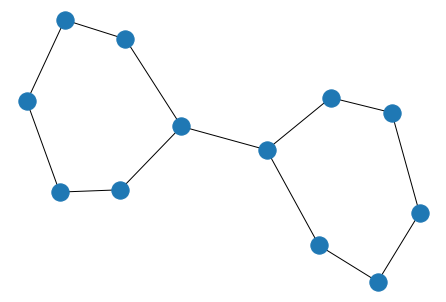

In [9]:
from pysmiles import read_smiles
import networkx as nx

smiles = 'C1CC[13CH2]CC1C1CCCCC1'
mol = read_smiles(smiles)

# atom vector (C only)
print(mol.nodes(data='element'))
# adjacency matrix
print(nx.to_numpy_matrix(mol))

nx.draw(mol)

In [10]:
X_smiles = [ 'CCCCCCC'  , 'C1CC[13CH2]CC1C1CCCCC1' , 'CC' , 'C1CC[13CH2]CC1C1CCCCC1' , 'CCCCCC',
           'C1CC[13CH2]CC1C1CCCCC1' , 'CCCCCCC' , 'C1CC[13CH2]CC1C1CCCCC1' , 'CCCC' , 'C1CC[13CH2]CC1C1CCCCC1',
           'CCCCCCC']
Y_train = [1,0,1,0,1,0,1,0,1,0,1]


In [11]:
import numpy as np

X_train = []

for j in range(len(X_smiles)):
  x = X_smiles[j]
  mol = read_smiles(x)

  # edeges of the graph
  edg_list =  list(nx.to_edgelist(mol))

  final_edg = np.zeros(( 2, len(edg_list) ) )
  for i in range( len(edg_list) ):
    final_edg[0][i] = edg_list[i][0]
    final_edg[1][i] = edg_list[i][1]

  edge_index = torch.tensor(final_edg , dtype=torch.long)
  edge_index

  # feature of nodes
  ft_nodes = list(mol.nodes(data='element'))

  final_nodes = np.zeros( ( len(ft_nodes) , 3) )
  for i in range( len(ft_nodes) ):  
    if(ft_nodes[i][1] == 'C'):
      final_nodes[i][0] = 1
      final_nodes[i][1] = 2
      final_nodes[i][2] = 3

  x = torch.tensor(final_nodes, dtype=torch.float)



  # final 
  data = Data(x=x, edge_index=edge_index , y = torch.tensor(Y_train[j], dtype=torch.float) ) 
  X_train.append(data)

In [12]:
print(len(X_train) , len(Y_train) , X_train[0]  , Y_train[0] )

11 11 Data(edge_index=[2, 6], x=[7, 3], y=1.0) 1


In [13]:
loader = DataLoader(X_train, batch_size=4)


In [14]:
for b in loader:
  print(b)

Batch(batch=[33], edge_index=[2, 33], x=[33, 3], y=[4])
Batch(batch=[37], edge_index=[2, 37], x=[37, 3], y=[4])
Batch(batch=[23], edge_index=[2, 22], x=[23, 3], y=[3])


In [15]:
from torch_scatter import scatter_add

FEATURE_NODE_NB = 3

FEATURE_GNN_NB = 10


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv( FEATURE_NODE_NB , 16)
        self.conv2 = GCNConv(16, FEATURE_GNN_NB)
        
        self.fc1 = torch.nn.Linear( FEATURE_GNN_NB , 8)  
        self.fc2 = torch.nn.Linear(8, 5)
        self.fc3 = torch.nn.Linear(5, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        # care !!! sum only within same mol
        if self.training:
          x = scatter_add(x, data.batch, dim=0)
        else: 
          x = torch.sum(x, dim=0)

        x = F.relu( self.fc1(x) )
        x = F.relu( self.fc2(x) )
        x = self.fc3(x)

        return x#F.log_softmax(x, dim=1)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
print(model)
#loader = DataLoader(X_train, batch_size=3)
#data = loader[0].to(device)
data = X_train[1]

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
lossF = torch.nn.L1Loss()

model.train()
for epoch in range(1000):

    for b in loader:
      optimizer.zero_grad()
      data = b
      out = model(data)

      # compute loss and backprop
      loss = lossF( torch.squeeze(out) , data.y )
      loss.backward()
      optimizer.step()
    
    print(loss)

Net(
  (conv1): GCNConv(3, 16)
  (conv2): GCNConv(16, 10)
  (fc1): Linear(in_features=10, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=1, bias=True)
)
tensor(0.8960, grad_fn=<L1LossBackward>)
tensor(0.6426, grad_fn=<L1LossBackward>)
tensor(0.6239, grad_fn=<L1LossBackward>)
tensor(0.5919, grad_fn=<L1LossBackward>)
tensor(0.6277, grad_fn=<L1LossBackward>)
tensor(0.5926, grad_fn=<L1LossBackward>)
tensor(0.5745, grad_fn=<L1LossBackward>)
tensor(0.5538, grad_fn=<L1LossBackward>)
tensor(0.5537, grad_fn=<L1LossBackward>)
tensor(0.5676, grad_fn=<L1LossBackward>)
tensor(0.5028, grad_fn=<L1LossBackward>)
tensor(0.6219, grad_fn=<L1LossBackward>)
tensor(0.6238, grad_fn=<L1LossBackward>)
tensor(0.5309, grad_fn=<L1LossBackward>)
tensor(0.4663, grad_fn=<L1LossBackward>)
tensor(0.5136, grad_fn=<L1LossBackward>)
tensor(0.5191, grad_fn=<L1LossBackward>)
tensor(0.4732, grad_fn=<L1LossBackward>)
tensor(0.4753, grad_fn=<L1L

In [17]:
SAVE_PATH = 'test_model.pth'

torch.save(model.state_dict()  , SAVE_PATH)

In [18]:
model_l = Net()
model_l.load_state_dict(torch.load(SAVE_PATH))
model_l.eval()

model_l(X_train[1])

tensor([0.0166], grad_fn=<AddBackward0>)

In [19]:
#